In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

print("Library berhasil di-import!")
print(f"TensorFlow Version: {tf.__version__}")

Library berhasil di-import!
TensorFlow Version: 2.19.0


In [2]:
# Membaca file csv, melewati 2 baris pertama yang berisi header ganda/kosong
df_raw = pd.read_csv('Exasens.csv', header=None)


df = df_raw.iloc[2:, 0:9].copy()


df.columns = [
    'Diagnosis',      # Target Label (COPD, HC, Asthma, Infected)
    'ID',             # ID Pasien
    'Imaginary_Min',  # Sensor Permittivity (Imaginary Part Min)
    'Imaginary_Avg',  # Sensor Permittivity (Imaginary Part Avg)
    'Real_Min',       # Sensor Permittivity (Real Part Min)
    'Real_Avg',       # Sensor Permittivity (Real Part Avg)
    'Gender',         # Gender (0=Wanita, 1=Pria)
    'Age',            # Umur Pasien
    'Smoking'         # Status Merokok
]

print("Dataset berhasil dibaca dan kolom dinamai ulang.")
df.head() # Menampilkan 5 data teratas mentah

Dataset berhasil dibaca dan kolom dinamai ulang.


,Diagnosis,ID,Imaginary_Min,Imaginary_Avg,Real_Min,Real_Avg,Gender,Age,Smoking
2,NaN,NaN,Min,Avg.,Min,Avg.,NaN,NaN,NaN
3,COPD,301-4,-320.61,-300.5635307,-495.26,-464.1719907,1,77,2
4,COPD,302-3,-325.39,-314.7503595,-473.73,-469.2631404,0,72,2
5,COPD,303-3,-323,-317.4360556,-476.12,-471.8976667,1,73,3
6,COPD,304-4,-327.78,-317.3996698,-473.73,-468.856388,1,76,2


In [3]:
# Daftar kolom yang harus berupa angka
cols_numeric = ['Imaginary_Min', 'Imaginary_Avg', 'Real_Min', 'Real_Avg', 'Gender', 'Age', 'Smoking']

# Loop untuk mengubah tipe data menjadi numeric (float/int)
for col in cols_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("--- INFORMASI DATASET ---")
print(f"Jumlah Baris: {df.shape[0]}")
print(f"Jumlah Kolom: {df.shape[1]}")
print("\nInfo Tipe Data Terbaru:")
df.info()

--- INFORMASI DATASET ---
Jumlah Baris: 400
Jumlah Kolom: 9

Info Tipe Data Terbaru:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 2 to 401
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Diagnosis      399 non-null    object 
 1   ID             399 non-null    object 
 2   Imaginary_Min  100 non-null    float64
 3   Imaginary_Avg  100 non-null    float64
 4   Real_Min       100 non-null    float64
 5   Real_Avg       100 non-null    float64
 6   Gender         399 non-null    float64
 7   Age            399 non-null    float64
 8   Smoking        399 non-null    float64
dtypes: float64(7), object(2)
memory usage: 28.3+ KB


In [4]:
# Menghapus baris yang nilai Diagnosis-nya kosong atau sensornya kosong
df_clean = df.dropna(subset=['Diagnosis', 'Imaginary_Min'])

print("--- LAPORAN KONDISI DATA ---")
print(f"Jumlah Data Sebelum Cleaning: {df.shape[0]}")
print(f"Jumlah Data Setelah Cleaning: {df_clean.shape[0]}")
print("\nSebaran Kelas Diagnosis:")
print(df_clean['Diagnosis'].value_counts())

--- LAPORAN KONDISI DATA ---
Jumlah Data Sebelum Cleaning: 400
Jumlah Data Setelah Cleaning: 100

Sebaran Kelas Diagnosis:
Diagnosis
COPD        40
HC          40
Asthma      10
Infected    10
Name: count, dtype: int64


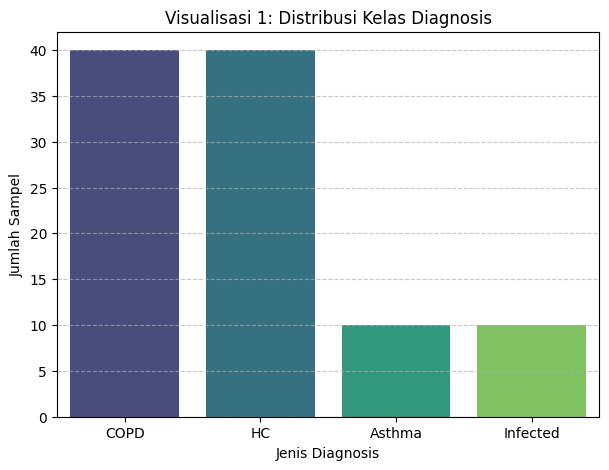

In [5]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df_clean, x='Diagnosis', palette='viridis')

plt.title('Visualisasi 1: Distribusi Kelas Diagnosis')
plt.xlabel('Jenis Diagnosis')
plt.ylabel('Jumlah Sampel')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

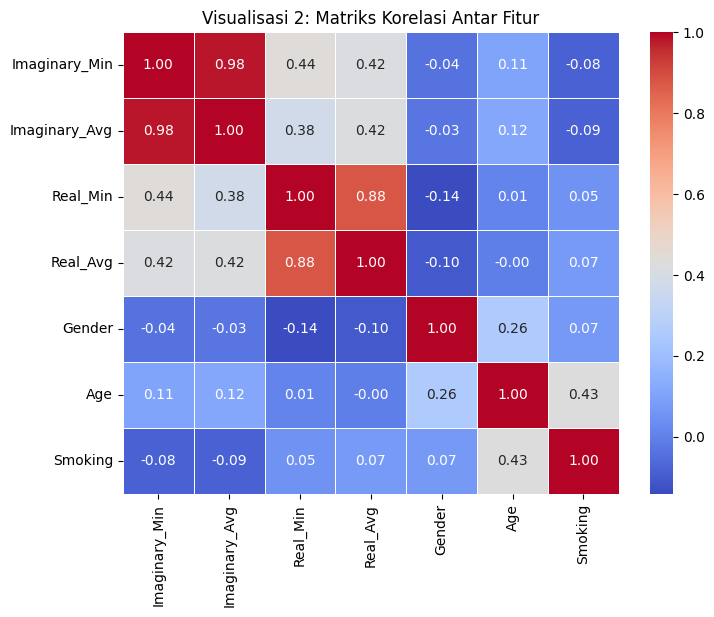

In [6]:
plt.figure(figsize=(8, 6))

df_corr = df_clean.drop(columns=['ID', 'Diagnosis'])

sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Visualisasi 2: Matriks Korelasi Antar Fitur')
plt.show()

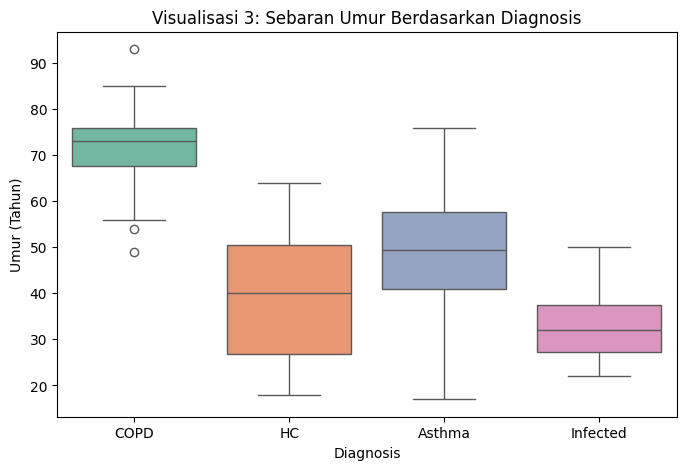

In [7]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_clean, x='Diagnosis', y='Age', palette='Set2')

plt.title('Visualisasi 3: Sebaran Umur Berdasarkan Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Umur (Tahun)')
plt.show()

In [8]:
le = LabelEncoder()

# Mengubah kolom 'Diagnosis' menjadi angka
df_clean['Diagnosis_Code'] = le.fit_transform(df_clean['Diagnosis'])

# Menampilkan hasil encoding agar tahu kode angkanya
print("--- HASIL ENCODING TARGET ---")
for i, label in enumerate(le.classes_):
    print(f"Kelas {label} diubah menjadi angka: {i}")

# Cek hasil perubahan di tabel
df_clean[['Diagnosis', 'Diagnosis_Code']].head()

--- HASIL ENCODING TARGET ---
Kelas Asthma diubah menjadi angka: 0
Kelas COPD diubah menjadi angka: 1
Kelas HC diubah menjadi angka: 2
Kelas Infected diubah menjadi angka: 3


,Diagnosis,Diagnosis_Code
3,COPD,1
4,COPD,1
5,COPD,1
6,COPD,1
7,COPD,1


In [9]:
# 1. Tentukan Fitur (X) dan Target (y)

X = df_clean.drop(columns=['ID', 'Diagnosis', 'Diagnosis_Code'])
y = df_clean['Diagnosis_Code']

# 2. Bagi Data: 80% Training, 20% Testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah Data Latih (Training): {X_train.shape[0]} baris")
print(f"Jumlah Data Uji (Testing)   : {X_test.shape[0]} baris")

Jumlah Data Latih (Training): 80 baris
Jumlah Data Uji (Testing)   : 20 baris


In [10]:
scaler = StandardScaler()

# Hitung rata-rata dan standar deviasi hanya dari data latih (agar tidak bocor/leakage)
X_train_scaled = scaler.fit_transform(X_train)

# Terapkan rumus yang sama ke data uji
X_test_scaled = scaler.transform(X_test)

print("Data berhasil dinormalisasi (Scaling).")
print("Contoh data setelah scaling (5 baris pertama):")
print(X_train_scaled[:5])

Data berhasil dinormalisasi (Scaling).
Contoh data setelah scaling (5 baris pertama):
[[-0.4484702  -0.48701952  0.14490514 -0.49997091  0.77459667  1.17262279
   0.42214126]
 [-0.80565266 -0.92952871 -0.95805647 -0.35867467  0.77459667 -1.52416884
  -1.11291786]
 [-0.4484702  -0.54787215 -0.95805647 -0.39275791  0.77459667 -1.57232584
  -1.11291786]
 [-0.4484702  -0.51421871  0.14490514  0.38980141 -1.29099445 -1.28338387
   0.42214126]
 [-0.80565266 -0.67093871 -1.25894037 -0.16934359  0.77459667  0.01685495
  -1.11291786]]


In [11]:
print("Training Model 1: K-Nearest Neighbors (Baseline)...")
start_time = time.time()

# 1. Inisialisasi Model
model_knn = KNeighborsClassifier(n_neighbors=5)

# 2. Training (Wajib pakai data yang sudah di-scaling!)
model_knn.fit(X_train_scaled, y_train)

# 3. Prediksi
y_pred_knn = model_knn.predict(X_test_scaled)

# 4. Hitung Waktu & Akurasi
knn_time = time.time() - start_time
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"Selesai dalam {knn_time:.4f} detik")
print(f"Akurasi Baseline (KNN): {acc_knn*100:.2f}%")
print("\nClassification Report (KNN):")
print(classification_report(y_test, y_pred_knn))


joblib.dump(model_knn, 'model_exasens_knn.pkl')


Training Model 1: K-Nearest Neighbors (Baseline)...
Selesai dalam 0.0068 detik
Akurasi Baseline (KNN): 70.00%

Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.80      1.00      0.89         8
           2       0.71      0.62      0.67         8
           3       0.50      0.50      0.50         2

    accuracy                           0.70        20
   macro avg       0.50      0.53      0.51        20
weighted avg       0.66      0.70      0.67        20



['model_exasens_knn.pkl']

In [12]:
print("Training Model 2: Random Forest (Advanced)...")
start_time = time.time()

# Inisialisasi Model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training (Random Forest bisa bekerja baik dengan data asli atau scaled)
model_rf.fit(X_train, y_train)

# Prediksi
y_pred_rf = model_rf.predict(X_test)

# Hitung Waktu & Akurasi
rf_time = time.time() - start_time
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Selesai dalam {rf_time:.4f} detik")
print(f"Akurasi Advanced (Random Forest): {acc_rf*100:.2f}%")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

joblib.dump(model_rf, 'model_exasens_rf.pkl')

Training Model 2: Random Forest (Advanced)...
Selesai dalam 0.1803 detik
Akurasi Advanced (Random Forest): 70.00%

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.75      0.75      0.75         8
           2       0.67      0.75      0.71         8
           3       0.50      0.50      0.50         2

    accuracy                           0.70        20
   macro avg       0.73      0.62      0.66        20
weighted avg       0.72      0.70      0.70        20



['model_exasens_rf.pkl']

Training Model 3: Deep Learning (MLP)...
Selesai dalam 14.1687 detik
Akurasi Deep Learning: 60.00%


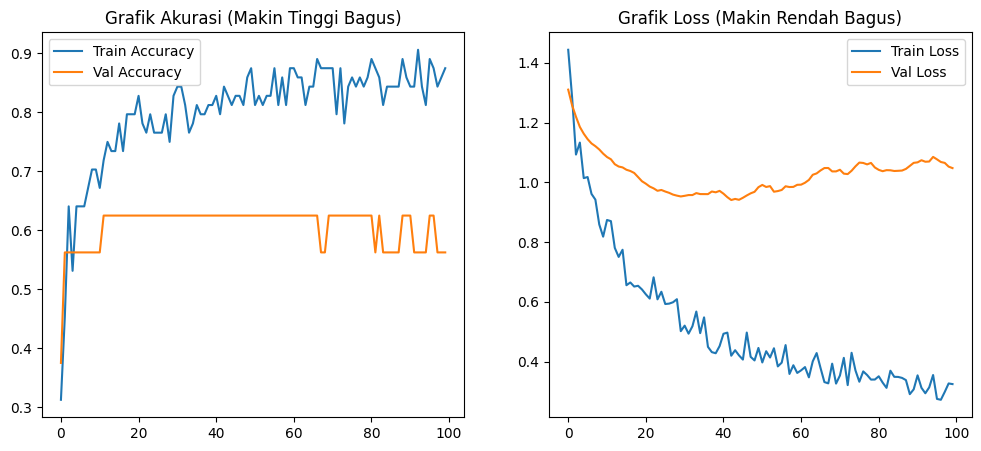

Model berhasil disimpan!


In [13]:
print("Training Model 3: Deep Learning (MLP)...")

# Persiapan Target Khusus DL (Harus One-Hot Encoding)
y_train_dl = to_categorical(y_train, num_classes=4)
y_test_dl = to_categorical(y_test, num_classes=4)

# 1. Definisi Arsitektur (Sesuai Syarat: Min 2 Hidden Layers)
model_dl = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

# 2. Compile
model_dl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Training (Simpan history untuk plot wajib)
start_time = time.time()
history = model_dl.fit(
    X_train_scaled, y_train_dl,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    verbose=0
)
dl_time = time.time() - start_time

# 4. Evaluasi
loss, acc_dl = model_dl.evaluate(X_test_scaled, y_test_dl, verbose=0)
print(f"Selesai dalam {dl_time:.4f} detik")
print(f"Akurasi Deep Learning: {acc_dl*100:.2f}%")


plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Grafik Akurasi (Makin Tinggi Bagus)')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Grafik Loss (Makin Rendah Bagus)')
plt.legend()

plt.show()
# Simpan model ke dalam penyimpanan sementara Colab
model_dl.save('model_exasens_mlp.h5')
print("Model berhasil disimpan!")

--- TABEL PERBANDINGAN MODEL ---
                      Model  Accuracy  Training Time (sec)
0            KNN (Baseline)       0.7             0.006781
1  Random Forest (Advanced)       0.7             0.180344
2       Deep Learning (MLP)       0.6            14.168684


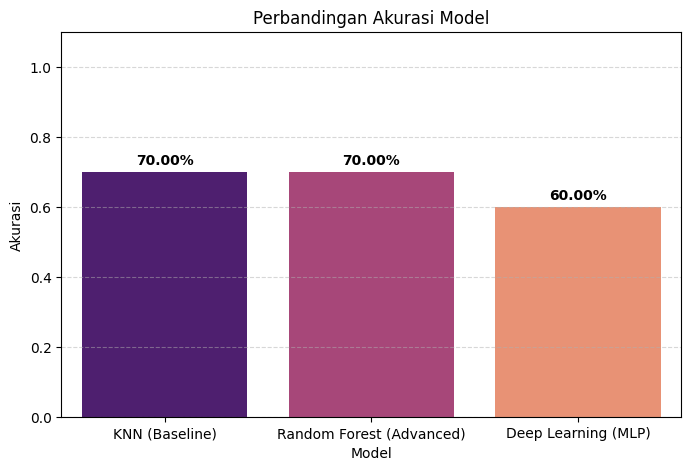

In [14]:
# 1. Membuat DataFrame Perbandingan
results = pd.DataFrame({
    'Model': ['KNN (Baseline)', 'Random Forest (Advanced)', 'Deep Learning (MLP)'],
    'Accuracy': [acc_knn, acc_rf, acc_dl],
    'Training Time (sec)': [knn_time, rf_time, dl_time]
})

# Urutkan dari akurasi tertinggi
results = results.sort_values(by='Accuracy', ascending=False)

print("--- TABEL PERBANDINGAN MODEL ---")
print(results)

# 2. Visualisasi Perbandingan (Bar Chart)
plt.figure(figsize=(8, 5))
sns.barplot(data=results, x='Model', y='Accuracy', palette='magma')

plt.title('Perbandingan Akurasi Model')
plt.ylim(0, 1.1)
plt.ylabel('Akurasi')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Menampilkan angka di atas batang
for index, row in results.iterrows():
    plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy*100:.2f}%",
             color='black', ha="center", fontweight='bold')

plt.show()